In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd 
model_df = pd.read_csv("drive/My Drive/Project/machinesample103k.csv")
model_df2 = pd.read_csv("drive/My Drive/Project/humansample18k.csv")
#model_df = pd.read_csv("drive/My Drive/3A2M/AllData/SVM/Train/14lac.csv")
#model_df2 = pd.read_csv("drive/My Drive/3A2M/AllData/SVM/Test/p7.csv")

In [6]:
%%capture
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re, string
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
plt.style.use('ggplot')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

import os
!pip install scikit-plot
import scikitplot as skplt

In [7]:
model_df

,Unnamed: 0,title,directions,NER,genre,label
0,0,Monster Cookies,"[""Mix in order given."", ""Drop by tablespoons o...","[""eggs"", ""brown sugar"", ""white sugar"", ""vanill...",bakery,1
1,1,Peaches Supreme,"[""Wash and drain the peaches."", ""Bring 2 quart...","[""peaches"", ""fresh raspberry"", ""sugar"", ""white...",bakery,1
2,2,Peach Cream Royale,"[""Mix crumbs and butter."", ""Press 1/3 crumb mi...","[""chocolate wafer crumbs"", ""vanilla wafer crum...",bakery,1
3,3,Grappa Cream,"[""Whip the cream until well thickened but not ...","[""heavy cream"", ""sugar"", ""salt"", ""grappa""]",bakery,1
4,4,Salty Chihuahua,"[""Combine juice, tequila, and liqueur; stir we...","[""fresh red grapefruit juice"", ""silver tequila...",bakery,1
...,...,...,...,...,...,...
103495,103495,Seitan Kielbasa,"[""Put the 2 quarts of water in a large pot. Ad...","[""BROTH"", ""water"", ""onion powder"", ""SEITAN"", ""...",fusion,9
103496,103496,kebbeh in pan,"[""Chop the onions"", ""Put 3 tablespoon oil in a...","[""Brown bulgur"", ""meat"", ""Pepper"", ""cinnamon"",...",fusion,9
103497,103497,Stromboli,"[""Cook Italian sausage; slice sausage, then br...","[""hot Italian sausage"", ""Italian sausage"", ""pe...",fusion,9
103498,103498,Jaegerschnitzel,"[""In a large skillet, saute the mushrooms in b...","[""mushrooms"", ""butter"", ""veal cutlets"", ""salt""...",fusion,9


In [8]:
#model_df2 = pd.read_csv("drive/My Drive/3A2M/AllData/SVM/Test/p3.csv")

In [9]:
model_df2

,Unnamed: 0,title,directions,NER,genre,label
0,0,Hard Candy,Mix first 3 ingredients in a large saucepan. S...,"[""sugar"", ""light corn syrup"", ""water"", ""powder...",bakery,1
1,1,Peanut Butter Cookies,Cream the shortening sugar eggs and vanilla. S...,"[""shortening"", ""sugar"", ""brown sugar"", ""flour""...",bakery,1
2,2,No Bake Cheesecake,Mix cream cheese and sugar with electric mixer...,"[""cream cheese"", ""sugar"", ""graham cracker crust""]",bakery,1
3,3,Too Good To Be A Dessert,Mix all ingredients and chill. And serve.,"[""pineapple"", ""cottage cheese"", ""sugar""]",bakery,1
4,4,Dirt Cake,Crush or blend cookies set aside. Cream butter...,"[""Oreos"", ""cream cheese"", ""margarine"", ""milk"",...",bakery,1
...,...,...,...,...,...,...
17995,17995,Fun Putty,Mix all ingredients together until blended. If...,"[""liquid starch"", ""white glue"", ""food coloring""]",Fusion,9
17996,17996,Lazy Man'S Holupschi,Fry ground beef in oil for 1 or 2 min. Add oni...,"[""ground beef"", ""onion"", ""oil"", ""salt"", ""tomat...",Fusion,9
17997,17997,Gobs,Put in pan and cook until thick the flour and ...,"[""flour"", ""milk"", ""sugar"", ""Crisco"", ""salt"", ""...",Fusion,9
17998,17998,Pico De Gallo,Finely chop all ingredients and combine. If to...,"[""onion"", ""tomato"", ""serrano peppers"", ""clove ...",Fusion,9


**Fix Directions**

In [11]:
def cleanDirections(data):
  ner_list = []
  for ing in data:
    s = ing.strip("[]")
    s = s.split(",")
    strng = ""
    for i in range(len(s)):
      strng = strng + " " + (s[i].translate(str.maketrans('', '', '""')))
    ner_list.append(strng.lstrip())
  return ner_list

In [14]:
sampled_model_df = model_df.sample(n=103500)
sampled_model_df2 = model_df2.sample(n=18000)

In [16]:
ner_list_train = cleanDirections(sampled_model_df.directions)
ner_list_test  = cleanDirections(sampled_model_df2.directions)

In [17]:
sampled_model_df["direction_cleaned"] = ner_list_train
sampled_model_df2["direction_cleaned"] = ner_list_test

In [18]:
sampled_model_df.direction_cleaned[0:5]

13026    Place potatoes  carrots and onions in crock po...
45168    Heat oil in a large  heavy pot.  Brown short r...
37648    Combine the carrots  turnips  onion  garlic  t...
69711    Preheat the oven to 350 degrees F (175 degrees...
49258    Spray a 9x13 inch oval baking dish with cookin...
Name: direction_cleaned, dtype: object

In [19]:
title_train = sampled_model_df['direction_cleaned'].values
y_train = sampled_model_df['label'].values

title_test = sampled_model_df2['direction_cleaned'].values
y_test = sampled_model_df2['label'].values

#unlabeled_sentences = active_df['title'].values

#sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.20, random_state=42)

In [20]:
sentences_train = title_train
sentences_test = title_test

In [21]:
sentences_train.shape

(103500,)

**Embedding From microsoft/mpnet-base**

In [22]:
%%capture
!pip3 install -U sentence-transformers

In [24]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')

#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences_train)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [25]:
test_embeddings = model.encode(sentences_test)

In [26]:
X_train = embeddings
X_test  = test_embeddings

#unlabeled_test = vectorizer.transform(unlabeled_sentences)

In [27]:
X_train.shape

(103500, 768)

**Logistic Regression**

In [28]:
from sklearn.linear_model import LogisticRegression
pipe = LogisticRegression(random_state=42, max_iter=500)
pipe.fit(X_train, y_train)  # apply scaling on training data
y_pred = pipe.predict(X_test)
y_train_pred = pipe.predict(X_train)
print("Train_Accuracy:",metrics.accuracy_score(y_train, y_train_pred))
print("Test_Accuracy:",metrics.accuracy_score(y_test, y_pred))

Train_Accuracy: 0.44603864734299514
Test_Accuracy: 0.42055555555555557


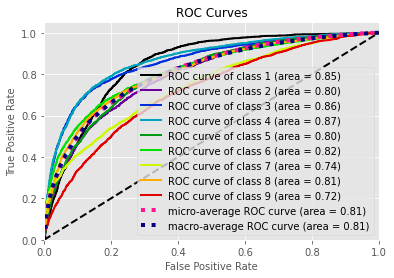

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


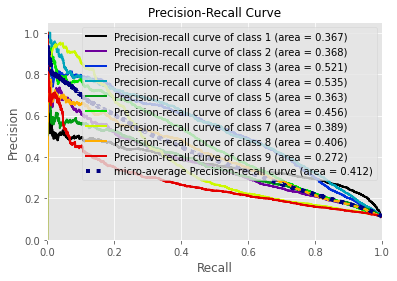

In [29]:
predicted_probas = pipe.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, predicted_probas)
plt.show()
skplt.metrics.plot_precision_recall_curve(y_test, predicted_probas)
plt.show()

**SVM**

In [30]:
#Import svm model
from sklearn import svm
from sklearn import metrics
#Create a svm Classifier
clf = svm.SVC(kernel='linear', probability=True) # Linear Kernel
#Train the model using the training sets
clf.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)
print("Train_Accuracy:",metrics.accuracy_score(y_train, y_train_pred))
print("Test_Accuracy:",metrics.accuracy_score(y_test, y_pred))

Train_Accuracy: 0.4532657004830918
Test_Accuracy: 0.42388888888888887


In [ ]:
predicted_probas = clf.predict_proba(X_test)   ## if you run properly SVM, then run this cell it will work, SVM takes 55 mins :3 
skplt.metrics.plot_roc(y_test, predicted_probas)
plt.show()
skplt.metrics.plot_precision_recall_curve(y_test, predicted_probas)
plt.show()

**Multinomial Naive Bayes**

In [ ]:
#from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import numpy as np
#Create a Gaussian Classifier
gnb = MultinomialNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
y_train_pred = gnb.predict(X_train)
print("Train_Accuracy:",metrics.accuracy_score(y_train, y_train_pred))
print("Test_Accuracy:",metrics.accuracy_score(y_test, y_pred))

ValueError: ignored

In [ ]:
predicted_probas = gnb.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, predicted_probas)
plt.show()
skplt.metrics.plot_precision_recall_curve(y_test, predicted_probas)
plt.show()

**Embedding**

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
#u_test = tokenizer.texts_to_sequences(unlabeled_sentences)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])
print(vocab_size)

In [ ]:
maxlen = 512

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
#u_test = pad_sequences(u_test, padding='post', maxlen=maxlen)

print(X_train[2, :])

**Neural Network Plotting**

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

**Neural Network Model**

In [ ]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
embedding_dim = 300

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
yy_train = np_utils.to_categorical(encoded_Y)
print(yy_train.shape)

encoder2 = LabelEncoder()
encoder2.fit(y_test)
encoded2_Y = encoder.transform(y_test)
yy_test = np_utils.to_categorical(encoded2_Y)
print(yy_test.shape)

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(256, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(9, activation='softmax')) #sigmoid
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy']) #binary
model.summary()


**Training and Evaluation**

In [ ]:
history = model.fit(X_train, yy_train,epochs=20,verbose=True,validation_data=(X_test, yy_test),batch_size=32)
loss, accuracy = model.evaluate(X_train, yy_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, yy_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
plot_history(history)

Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=50, random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
y_train_pred = rfc.predict(X_train)
print("Test_Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Train_Accuracy:",metrics.accuracy_score(y_train, y_train_pred))


In [ ]:
predicted_probas = rfc.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, predicted_probas)
plt.show()
skplt.metrics.plot_precision_recall_curve(y_test, predicted_probas)
plt.show()